## Import

In [1]:
import os
import json
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import decoupler as dc
import scanpy as sc
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

/home/rossi/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "output_phenotypes"

In [3]:
output_path = os.path.join(path, 'infl_vs_others')

In [37]:
#th_path = 'figures/volcano_plots/th_75_25'
#os.makedirs("figures/volcano_plots", exist_ok=True)

## Load

In [4]:
adata = sc.read_h5ad(os.path.join(path, 'adata_phenotype.h5ad'))

In [5]:
phenotype_key = 'phenotype'
cell_type_key = 'celltype'
sample_key = 'name'
patient_key = 'patient_id'
tissue_region_key = 'tissue_region'

In [6]:
adata.X = adata.layers['counts'].copy()

In [7]:
adata.obs[phenotype_key] = adata.obs[phenotype_key].replace({
    'excluded': 'others',
    'ignored': 'others'
})

In [8]:
with open(os.path.join(path, "genes_no_source_75_25.json"), "r") as f: genes_no_source = json.load(f)

## All cells

In [9]:
adata.obs[cell_type_key].value_counts()

celltype
Cancer cell           1681593
Fibroblast             395275
Macrophage             209763
Plasma cell            206786
Endothelial cell       153663
T cell                  87263
Smooth muscle cell      84152
Neutrophil              82467
B cell                  48559
Epithelial cell         29568
Dendritic cell          18106
Mast cell                9531
Schwann cell             5591
Name: count, dtype: int64

### Counts dataframe

In [10]:
adata.obs['patient_phenotype'] = (adata.obs[patient_key].astype(str) + " - " + adata.obs[phenotype_key].astype(str))
adata.obs['patient_phenotype'] = adata.obs['patient_phenotype'].astype('category')

counts_cancer = pd.DataFrame(adata.X.todense() if hasattr(adata.X, "todense") else adata_cancer.X, 
                             columns=adata.var_names, 
                             index=adata.obs_names)

counts_cancer['patient_phenotype'] = adata.obs['patient_phenotype'].values
aggregated_counts = counts_cancer.groupby('patient_phenotype').sum()
aggregated_counts = aggregated_counts.astype(int)
aggregated_counts = aggregated_counts.groupby(level=0, axis=1).sum() # IMPORTANT: AGGREGATION OF DUPLICATED COLUMNS 

In [11]:
print(f"Genes: {aggregated_counts.shape[1]}")

# Filter out genes with low expression
# Keep genes with at least 10 counts in at least 3 patients
gene_keep = (aggregated_counts >= 10).sum(axis=0) >= 3
aggregated_counts = aggregated_counts.loc[:, gene_keep]

print(f"Genes left: {aggregated_counts.shape[1]}")

Genes: 380
Genes left: 380


### Metadata dataframe

In [12]:
adata.obs[phenotype_key] = adata.obs[phenotype_key].astype('category')

metadata_cancer = adata.obs.set_index('patient_phenotype')[[patient_key, phenotype_key]]

aggregated_metadata = metadata_cancer[~metadata_cancer.index.duplicated(keep='first')] # sure it is the one and only met
aggregated_metadata = aggregated_metadata.sort_index()
for col in aggregated_metadata.columns:
    aggregated_metadata[col] = aggregated_metadata[col].astype('category')

### DeSeq2

In [13]:
inference = DefaultInference(n_cpus=96)
dds = DeseqDataSet(
    counts=aggregated_counts,
    metadata=aggregated_metadata,
    design_factors=['phenotype'],
    refit_cooks=True,
    inference=inference,
)

In [14]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.17 seconds.

Fitting dispersion trend curve...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.16 seconds.

Fitting LFCs...
... done in 0.14 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 13 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [18]:
#dds.write(os.path.join(path, 'deseq.h5ad'))

In [15]:
# default: alpha=0.05, cooks_filter=True, independent_filter=True
stat = DeseqStats(dds, contrast=["phenotype", 'inflamed', 'others'], inference=inference)
stat.summary()

Log2 fold change & Wald test p-value: phenotype inflamed vs others
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A2M     9.035704e+04       -0.416191  0.231058 -1.801240  0.071665  0.297444
ACE2    8.648942e+04        0.307128  0.761727  0.403200  0.686801  0.872423
ACTA2   5.596876e+05       -0.579542  0.174562 -3.319979  0.000900  0.024305
ACTB    1.997365e+06       -0.419741  0.235920 -1.779167  0.075212  0.297444
ADAM28  1.131544e+04       -0.119133  0.407193 -0.292571  0.769850  0.901190
...              ...             ...       ...       ...       ...       ...
VEGFA   5.909271e+05       -0.454113  0.405093 -1.121010  0.262284  0.571465
VSIG4   7.713417e+03       -0.111371  0.426858 -0.260908  0.794164  0.913566
VSIR    3.210351e+04       -0.317843  0.235861 -1.347586  0.177791  0.475556
XBP1    4.555332e+05        0.230679  0.482162  0.478426  0.632347  0.849333
ZNF683  2.405632e+03       -0.168537  0.641680 -0.262650  0.792820       NaN

[380 row

Running Wald tests...
... done in 0.13 seconds.



In [16]:
results = stat.results_df

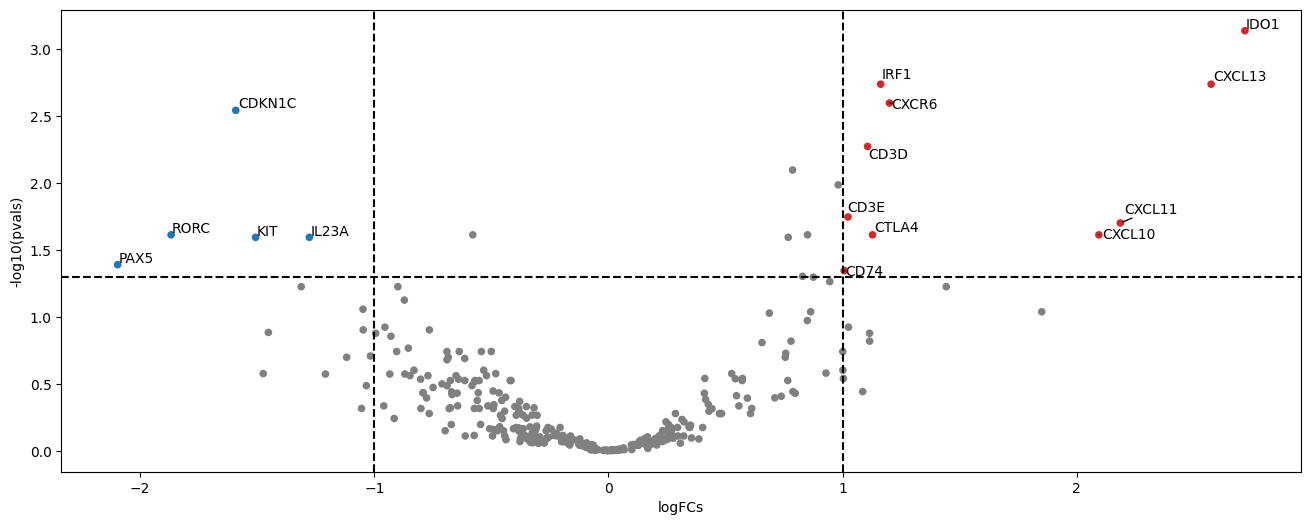

In [17]:
dc.plot_volcano_df(
    results,
    x='log2FoldChange', lFCs_thr=1,
    y='padj',
    top=40,
    figsize=(16, 6),
    #save='volcan_cancer.png'
)

In [18]:
results.to_csv(os.path.join(output_path, "de_results.csv"), index=True)

## Cancer cell

In [19]:
adata_cancer = adata[adata.obs[cell_type_key] == "Cancer cell"].copy()

In [20]:
adata_cancer.obs[patient_key].value_counts()

patient_id
a    242006
m    149478
k    148159
j    143443
f    142024
n    131863
l    125880
b    124199
e     92303
c     90544
o     84412
d     83715
i     78175
h     41762
g      3630
Name: count, dtype: int64

### Counts dataframe

In [21]:
adata_cancer.obs['patient_phenotype'] = (adata_cancer.obs[patient_key].astype(str) + " - " + adata_cancer.obs[phenotype_key].astype(str))
adata_cancer.obs['patient_phenotype'] = adata_cancer.obs['patient_phenotype'].astype('category')

counts_cancer = pd.DataFrame(adata_cancer.X.todense() if hasattr(adata_cancer.X, "todense") else adata_cancer.X, 
                             columns=adata_cancer.var_names, 
                             index=adata_cancer.obs_names)

counts_cancer['patient_phenotype'] = adata_cancer.obs['patient_phenotype'].values
aggregated_counts = counts_cancer.groupby('patient_phenotype').sum()
aggregated_counts = aggregated_counts.astype(int)
aggregated_counts = aggregated_counts.groupby(level=0, axis=1).sum() # IMPORTANT: AGGREGATION OF DUPLICATED COLUMNS 

In [22]:
print(f"Genes: {aggregated_counts.shape[1]}")

# Filter out genes with low expression
# Keep genes with at least 10 counts in at least 3 patients
gene_keep = (aggregated_counts >= 10).sum(axis=0) >= 3
aggregated_counts = aggregated_counts.loc[:, gene_keep]

print(f"Genes left: {aggregated_counts.shape[1]}")

Genes: 380
Genes left: 380


In [23]:
# Filter out genes which come from other sources
gene_keep = genes_no_source['Cancer cell']
aggregated_counts = aggregated_counts.loc[:, gene_keep]

print(f"Genes left: {aggregated_counts.shape[1]}")

Genes left: 265


### Metadata dataframe

In [24]:
adata_cancer.obs[phenotype_key] = adata_cancer.obs[phenotype_key].astype('category')

metadata_cancer = adata_cancer.obs.set_index('patient_phenotype')[[patient_key, phenotype_key]]

aggregated_metadata = metadata_cancer[~metadata_cancer.index.duplicated(keep='first')] # sure it is the one and only met
aggregated_metadata = aggregated_metadata.sort_index()

In [25]:
for col in aggregated_metadata.columns:
    aggregated_metadata[col] = aggregated_metadata[col].astype('category')

### DeSeq2

In [26]:
inference = DefaultInference(n_cpus=96)
dds = DeseqDataSet(
    counts=aggregated_counts,
    metadata=aggregated_metadata,
    design_factors=['phenotype'],
    refit_cooks=True,
    inference=inference,
)

In [27]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.10 seconds.

Fitting dispersion trend curve...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.09 seconds.

Fitting LFCs...
... done in 0.09 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 11 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [33]:
#dds.write(os.path.join(path, 'deseq.h5ad'))

In [28]:
# default: alpha=0.05, cooks_filter=True, independent_filter=True
stat_cancer = DeseqStats(dds, contrast=["phenotype", 'inflamed', 'others'], inference=inference)
stat_cancer.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: phenotype inflamed vs others
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
ACE2    8.722327e+04        0.324470  0.776600  0.417808  0.676087  0.890045
ACTA2   2.594940e+05       -0.294520  0.244834 -1.202934  0.229002  0.665897
ACTB    1.513307e+06       -0.277754  0.242182 -1.146882  0.251431  0.678339
ADAM28  5.289072e+03        0.369525  0.566961  0.651765  0.514553  0.822880
AIRE    1.994749e+03        1.181457  0.816358  1.447228       NaN       NaN
...              ...             ...       ...       ...       ...       ...
TUBB    1.057555e+05        0.080517  0.383170  0.210133  0.833564  0.938665
TXLNA   8.671268e+04       -0.076825  0.310782 -0.247200  0.804753  0.934048
UBE2C   1.042757e+05        0.555264  0.353594  1.570345  0.116335  0.503593
VSIR    1.510278e+04       -0.524930  0.444546 -1.180821  0.237674  0.671536
XBP1    3.909837e+05        0.581719  0.518081  1.122834  0.261508  0.684147

[265 row

... done in 0.09 seconds.



In [29]:
results_cancer = stat_cancer.results_df

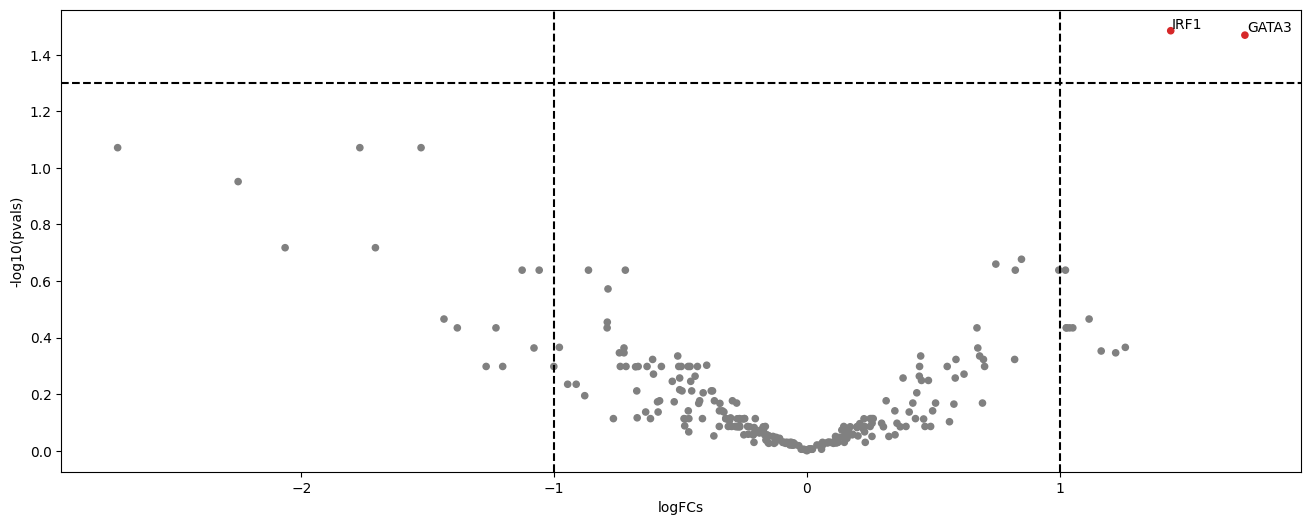

In [30]:
dc.plot_volcano_df(
    results_cancer,
    x='log2FoldChange', lFCs_thr=1,
    y='padj',
    top=60,
    figsize=(16, 6),
    #save='volcan_cancer.png'
)

In [31]:
results_cancer.to_csv(os.path.join(output_path, "de_results_cancer.csv"), index=True)